<a href="https://colab.research.google.com/github/michele1993/NMA_latentDynamics/blob/Michele/Copy_of_load_steinmetz_decisions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Loading of Steinmetz data

includes some visualizations

In [84]:
import numpy as np 
import matplotlib.pyplot as plt
from scipy.stats import zscore
from sklearn.decomposition import PCA

In [85]:
# @title Figure settings
from matplotlib import rcParams

rcParams['figure.figsize'] = [20, 4]
rcParams['font.size'] = 15
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['figure.autolayout'] = True

In [86]:
# @title Data retrieval
import os, requests

fname = []
for j in range(3):
  fname.append('steinmetz_part%d.npz'%j)
url = ["https://osf.io/agvxh/download"]
url.append("https://osf.io/uv3mw/download")
url.append("https://osf.io/ehmw2/download")

for j in range(len(url)):
  if not os.path.isfile(fname[j]):
    try:
      r = requests.get(url[j])
    except requests.ConnectionError:
      print("!!! Failed to download data !!!")
    else:
      if r.status_code != requests.codes.ok:
        print("!!! Failed to download data !!!")
      else:
        with open(fname[j], "wb") as fid:
          fid.write(r.content)

In [87]:
# REMOVE line below first time you run the colab 
%%script echo skipping 

# @title Data loading
alldat = np.array([])
for j in range(len(fname)):
  alldat = np.hstack((alldat,
                      np.load('steinmetz_part%d.npz'%j,
                              allow_pickle=True)['dat']))

skipping


`alldat` contains 39 sessions from 10 mice, data from Steinmetz et al, 2019. Time bins for all measurements are 10ms, starting 500ms before stimulus onset. The mouse had to determine which side has the highest contrast. For each `dat = alldat[k]`, you have the fields below. For extra variables, check out the extra notebook and extra data files (lfp, waveforms and exact spike times, non-binned). 

* `dat['mouse_name']`: mouse name
* `dat['date_exp']`: when a session was performed
* `dat['spks']`: neurons by trials by time bins.    
* `dat['brain_area']`: brain area for each neuron recorded. 
* `dat['ccf']`: Allen Institute brain atlas coordinates for each neuron. 
* `dat['ccf_axes']`: axes names for the Allen CCF. 
* `dat['contrast_right']`: contrast level for the right stimulus, which is always contralateral to the recorded brain areas.
* `dat['contrast_left']`: contrast level for left stimulus. 
* `dat['gocue']`: when the go cue sound was played. 
* `dat['response_time']`: when the response was registered, which has to be after the go cue. The mouse can turn the wheel before the go cue (and nearly always does!), but the stimulus on the screen won't move before the go cue.  
* `dat['response']`: which side the response was (`-1`, `0`, `1`). When the right-side stimulus had higher contrast, the correct choice was `-1`. `0` is a no go response. 
* `dat['feedback_time']`: when feedback was provided. 
* `dat['feedback_type']`: if the feedback was positive (`+1`, reward) or negative (`-1`, white noise burst).  
* `dat['wheel']`: turning speed of the wheel that the mice uses to make a response, sampled at `10ms`. 
* `dat['pupil']`: pupil area  (noisy, because pupil is very small) + pupil horizontal and vertical position.
* `dat['face']`: average face motion energy from a video camera. 
* `dat['licks']`: lick detections, 0 or 1.   
* `dat['trough_to_peak']`: measures the width of the action potential waveform for each neuron. Widths `<=10` samples are "putative fast spiking neurons". 
* `dat['%X%_passive']`: same as above for `X` = {`spks`, `pupil`, `wheel`, `contrast_left`, `contrast_right`} but for  passive trials at the end of the recording when the mouse was no longer engaged and stopped making responses. 
* `dat['prev_reward']`: time of the feedback (reward/white noise) on the previous trial in relation to the current stimulus time. 
* `dat['reaction_time']`: ntrials by 2. First column: reaction time computed from the wheel movement as the first sample above `5` ticks/10ms bin. Second column: direction of the wheel movement (`0` = no move detected).  


The original dataset is here: https://figshare.com/articles/dataset/Dataset_from_Steinmetz_et_al_2019/9598406

## ============ **Data organisation** ==============

In [88]:
print(alldat[11]['spks'].shape)
print(alldat[11]['contrast_right'].shape)

(698, 340, 250)
(340,)


In [89]:
for p in range(0,39): 
    print(p,' ',alldat[p]['mouse_name'])

0   Cori
1   Cori
2   Cori
3   Forssmann
4   Forssmann
5   Forssmann
6   Forssmann
7   Hench
8   Hench
9   Hench
10   Hench
11   Lederberg
12   Lederberg
13   Lederberg
14   Lederberg
15   Lederberg
16   Lederberg
17   Lederberg
18   Moniz
19   Moniz
20   Moniz
21   Muller
22   Muller
23   Muller
24   Radnitz
25   Radnitz
26   Radnitz
27   Radnitz
28   Radnitz
29   Richards
30   Richards
31   Richards
32   Richards
33   Richards
34   Tatum
35   Tatum
36   Tatum
37   Tatum
38   Theiler


Key: the data are organised in spike counts x time bin

In [90]:
def data_org(alldat,session_id = 11, ROI_number = 0): # e.g. ROI_number = 0:"vis ctx", 1:"thal", etc.

  assert 0 <= session_id <= 38, 'session_id is out of range, it should be between 0 and 38'

  brain_groups = [["VISa", "VISam", "VISl", "VISp", "VISpm", "VISrl"],  # visual cortex, ROI_number = 0
                ["CL", "LD", "LGd", "LH", "LP", "MD", "MG", "PO", "POL", "PT", "RT", "SPF", "TH", "VAL", "VPL", "VPM"], # thalamus, ROI_number = 1
                ["CA", "CA1", "CA2", "CA3", "DG", "SUB", "POST"],  # hippocampal, ROI_number = 2
                ["ACA", "AUD", "COA", "DP", "ILA", "MOp", "MOs", "OLF", "ORB", "ORBm", "PIR", "PL", "SSp", "SSs", "RSP","TT"],  # non-visual cortex, ROI_number = 3
                ["APN", "IC", "MB", "MRN", "NB", "PAG", "RN", "SCs", "SCm", "SCig", "SCsg", "ZI"],  # midbrain, ROI_number = 4
                ["ACB", "CP", "GPe", "LS", "LSc", "LSr", "MS", "OT", "SNr", "SI"],  # basal ganglia, ROI_number = 5
                ["BLA", "BMA", "EP", "EPd", "MEA"]  # cortical subplate, ROI_number = 6
                ]
 
  dat = alldat[session_id]
  
  ROI_nn = []
  nn_per_area = [] # store the number of neurons in each sub area of a "macro area" for indexing
  
  ROI = brain_groups[ROI_number]

  nn_per_area = dict()

  indx_counter = 0
  
  # Extract spikes from ROI:
  for r in ROI:
    roi_nn = dat['spks'][dat['brain_area']==r]
    ROI_nn.append(roi_nn)
    if roi_nn.shape[0] >0:
      indx_counter += roi_nn.shape[0] 
      nn_per_area[r] = indx_counter -1 # subtract one to get correct Python indx
       
      #nn_per_area.append((r,indx_counter)) # store n of neurons in that sub area # use this for list instead of dict
      

  # Return activations from same 'macro' area in the same tensor dimension as well as return   
  return np.concatenate(ROI_nn,axis=0), nn_per_area 


In [91]:
# Load the data:
r_data, dict_indx = data_org(alldat, session_id = 34, ROI_number = 0)



#Inspect data indexes 
print(dict_indx)
print(r_data.shape)



{'VISam': 74}
(75, 311, 250)


In [92]:
# Convert signal into frequency by averaging activity across n trials

def compute_frequency(alldat,n_aver_trials=5, time_bin = 0.01):

  n_trials = alldat.shape[1] // n_aver_trials
  
  
  # Ensure that if you have a big remainder at the end 
  # you compute the mean of that remainder and add it as a final trial
  
  remainder =  alldat.shape[1] - n_trials * n_aver_trials
  
  if  remainder >= n_aver_trials-2:
    frequency_spk = np.zeros((alldat.shape[0],n_trials + 1,alldat.shape[2]))
    sub_data = alldat[:,n_trials:]
    frequency_spk[:,-1:] = np.mean(sub_data, axis= 1, keepdims=True) / time_bin
  
  else:
    frequency_spk = np.zeros((alldat.shape[0],n_trials,alldat.shape[2])) 

  indexes = np.arange(0,n_trials+n_aver_trials ,n_aver_trials)
  
  t = 0
  for i in indexes[:-1]:
      sub_data = alldat[:,i:indexes[t+1]]
      frequency_spk[:,t:t+1] = np.mean(sub_data, axis= 1, keepdims=True) / time_bin
      t+=1
  

  return frequency_spk




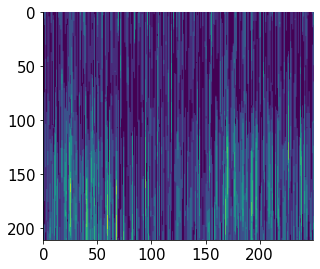

In [93]:
# Sliding averaged window:

VISl = r_data

window_len = 100 # in trials

last_step  = VISl.shape[1] - window_len
step_range = (np.arange(0, last_step, 1))

# init
spike_rate = np.zeros((VISl.shape[0], last_step, VISl.shape[2]))

ex_unit  = 30

# loop over neurons
for n in range(0, VISl.shape[0]):

 
  
  # slide trial window
  for p in step_range:
    
    # compute average and fill spike rate matrix
    for x in range(0, VISl.shape[1], window_len):
      trial_avg = VISl[n, np.arange(p, p+window_len, 1), :].mean(axis=0)
      trial_avg = trial_avg/0.01 # time average
      spike_rate[n,p,:] = trial_avg 



plt.imshow(spike_rate[ex_unit, :, :])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  


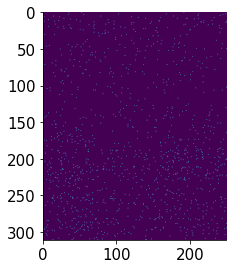

In [94]:
new_data = compute_frequency(r_data,n_aver_trials=5,time_bin =0.01)

fig = plt.figure(112)
ax1 = fig.add_subplot()

ax1.imshow(new_data[ex_unit, :, :])

ax2 = fig.add_subplot()

ax2.imshow(r_data[ex_unit, :, :])

plt.show()

#ax.set_ylim(0, 2)


**Prepare data for training the RNN (i.e. select a (sub) area for analysis and split neurons in two groups)**

In [95]:
print(spike_rate.shape)

(75, 211, 250)


In [96]:
# Remove baseline and normalise data trhough baseline
baseline_end = 50
baseline_mean = spike_rate[:,:,0:baseline_end].mean(axis=2, keepdims=True) 

r_data_2 = spike_rate[:,:,baseline_end:]


# Subtract baseline from signal to improve data
r_data_2 -= baseline_mean

r_data_2 = np.maximum(0,r_data_2)


# Extract region with most neurons
indexes = list(dict_indx.values())
roi_indx = np.argmax(indexes)



# Create indexes to divide data in training and testing:
if len(indexes) >1:
  init_indx = indexes[roi_indx-1] # take index marking the end of previous area
  final_indx = indexes[roi_indx]

else:
    init_indx = 0 # take index marking the end of previous area
    final_indx = indexes[roi_indx]


mid_indx = int((final_indx-init_indx)/2) + init_indx # need to add back initial indx as we are not starting from the beginning


training_nn = r_data_2[init_indx:mid_indx]
testing_nn = r_data_2[mid_indx:final_indx]


In [97]:
print(np.mean(np.equal(training_nn,testing_nn)))

0.3192064813628795


In [98]:
print(init_indx,mid_indx,final_indx)
print(training_nn.shape,testing_nn.shape)

0 37 74
(37, 211, 200) (37, 211, 200)


# **============ Data Analysis ============**

In [99]:
# Imports
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from matplotlib import pyplot as plt

**Define the RNN** 

In [100]:
class Net(nn.Module):
  
  def __init__(self, ncomp, NN1, NN2,lr = .005, bidi=True, batch_size=30):
    
    super(Net, self).__init__()

    self.batch_size = batch_size

    # play with some of the options in the RNN!
    self.rnn = nn.RNN(NN1, ncomp, num_layers = 1, dropout = 0,
                      bidirectional = bidi, nonlinearity = 'relu')
    self.fc = nn.Linear(ncomp, NN2)

    self.ncomp = ncomp
    
    self.optimizer = torch.optim.Adam(self.parameters(), lr=lr)
    self.loss = nn.MSELoss()

  
  
  def forward(self, x):

    y = self.rnn(x)[0]

    if self.rnn.bidirectional:
      # if the rnn is bidirectional, it concatenates the activations from the forward and backward pass
      # we want to add them instead, so as to enforce the latents to match between the forward and backward pass
      q = (y[:, :, :self.ncomp] + y[:, :, self.ncomp:])/2
    else:
      q = y

    # the softplus function is just like a relu but it's smoothed out so we can't predict 0
    # if we predict 0 and there was a spike, that's an instant Inf in the Poisson log-likelihood which leads to failure
    z = F.softplus(self.fc(q), 10)

    return z, q
  
  def Poisson_loss_update(self,lam, spk):

    loss = torch.mean(lam - spk * torch.log(lam))
    return loss



  def train(self,input,target,niter = 1000):

      # special thing:  we initialize the biases of the last layer in the neural network
      # we set them as the mean firing rates of the neurons.
      # this should make the initial predictions close to the mean, because the latents don't contribute much
      self.fc.bias.data[:] = input.mean((0,1))

      max_n_trials = input.shape[1]

      
      for k in range(niter):
          batch_indx = torch.randint(0, max_n_trials, (self.batch_size,))
          x = input[:,batch_indx,:]
          # the network outputs the single-neuron prediction and the latents
          y_hat, h = self(x)

          y_tar = target[:,batch_indx,:]
      # train the network with Poisson log-likelihood cost
          #loss = self.Poisson_loss_update(y_hat,y_tar)
          loss = self.loss(y_hat,y_tar)
          loss.backward()
          self.optimizer.step()
          self.optimizer.zero_grad()

          if k % 100 == 0:
            print(f'iteration {k}, cost {loss.item():.4f}')
    


In [101]:
torch.randint(0, 251, (30,))

tensor([193, 159,  28,  10, 147, 109,  94,  75, 248, 228,  34,  69, 153, 250,
        244, 105, 212, 137, 243,  97, 104, 211, 175, 160, 169, 216, 100,  44,
        144, 248])

In [102]:
# Define RNN for training


# Convert data to torch.tensor():
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')


print(np.mean(np.equal(training_nn,testing_nn)))

tr_nn  = torch.tensor(training_nn, device=device).float()
ts_nn = torch.tensor(testing_nn, device=device).float()

# Put them in the right shape for the RNN
tr_nn = torch.permute(tr_nn ,(2,1,0))
ts_nn = torch.permute(ts_nn,(2,1,0))




NN1 = tr_nn.shape[-1]
NN2 = ts_nn.shape[-1]

ncomp = 10



net = Net(ncomp, NN1, NN2,lr = 0.0005, bidi = True).to(device) # .0005


net.train(tr_nn,ts_nn, niter = 20000)

0.3192064813628795
iteration 0, cost 28.5406
iteration 100, cost 18.7624
iteration 200, cost 9.2845
iteration 300, cost 7.8565
iteration 400, cost 7.0527
iteration 500, cost 6.2455
iteration 600, cost 5.5745
iteration 700, cost 5.4060
iteration 800, cost 5.2717
iteration 900, cost 5.1541
iteration 1000, cost 5.0453
iteration 1100, cost 4.8944
iteration 1200, cost 4.8747
iteration 1300, cost 4.7462
iteration 1400, cost 4.6678
iteration 1500, cost 4.6513
iteration 1600, cost 4.5674
iteration 1700, cost 4.3989
iteration 1800, cost 4.4418
iteration 1900, cost 4.4110
iteration 2000, cost 4.4189
iteration 2100, cost 4.4014
iteration 2200, cost 4.3685
iteration 2300, cost 4.3041
iteration 2400, cost 4.2156
iteration 2500, cost 4.2772
iteration 2600, cost 4.2542
iteration 2700, cost 4.2418
iteration 2800, cost 4.1685
iteration 2900, cost 4.1961
iteration 3000, cost 4.2572
iteration 3100, cost 4.1800
iteration 3200, cost 4.2627
iteration 3300, cost 4.1412
iteration 3400, cost 4.1554
iteration 3

In [103]:
# y_hat, _ = net(tr_nn)
# x = torch.poisson(y_hat)
# ts_nn_numpy = ts_nn

# print(torch.sum(torch.eq(x,ts_nn_numpy))/torch.numel(x))

# print(x.shape)
# print(ts_nn_numpy.shape)


(200, 211, 37)
(200, 211, 37)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in true_divide
  from ipykernel import kernelapp as app


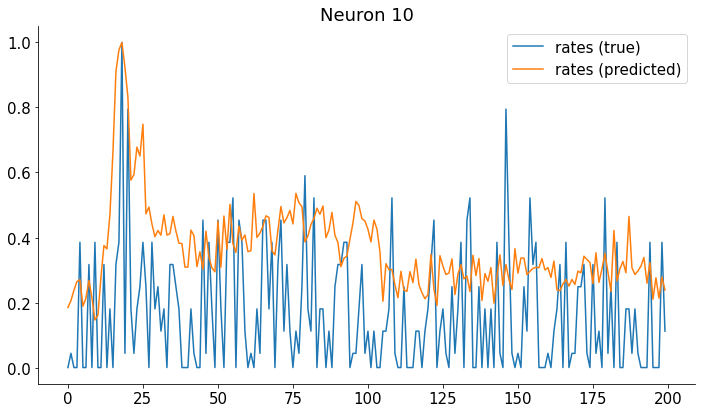

In [111]:
y_hat, _ = net(tr_nn)
#x = np.random.poisson(y_hat.detach().cpu().numpy())

x = y_hat.detach().cpu().numpy()

x = x / np.max(x, axis=0)

print(x.shape)



rpred = x

ts_nn_numpy = ts_nn.detach().cpu().numpy()
ts_nn_numpy = ts_nn_numpy / np.max(ts_nn_numpy, axis=0)

print(x.shape)

nn = 10
trial_n = 0
plt.figure(figsize=(10, 6))
plt.plot(ts_nn_numpy[:,trial_n, nn])
plt.plot(rpred[:,trial_n, nn])
#plt.plot(-.5 + x[:, nn, 0]/4)

plt.legend(['rates (true)', 'rates (predicted)', 'spikes'])
plt.title(f'Neuron {nn}')
plt.show()



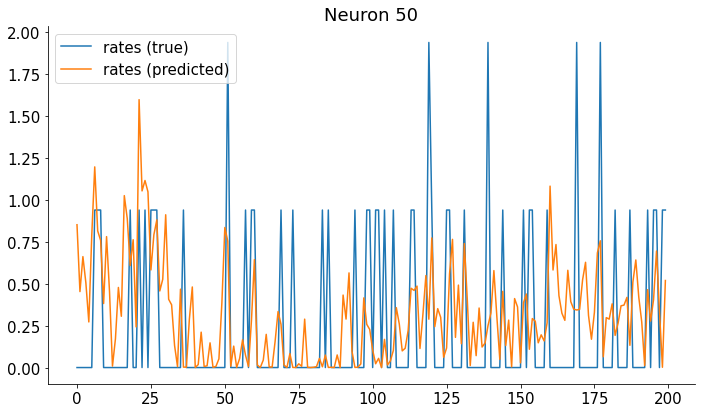

In [105]:
y_hat, _ = net(tr_nn)

rpred = y_hat.detach().cpu().numpy()

ts_nn_numpy = ts_nn.detach().cpu().numpy()



nn = 50
plt.figure(figsize=(10, 6))
plt.plot(ts_nn_numpy[:,nn, 0])
plt.plot(rpred[:,nn, 0])
#plt.plot(-.5 + x[:, nn, 0]/4)

plt.legend(['rates (true)', 'rates (predicted)', 'spikes'])
plt.title(f'Neuron {nn}')
plt.show()

(200, 211, 10)


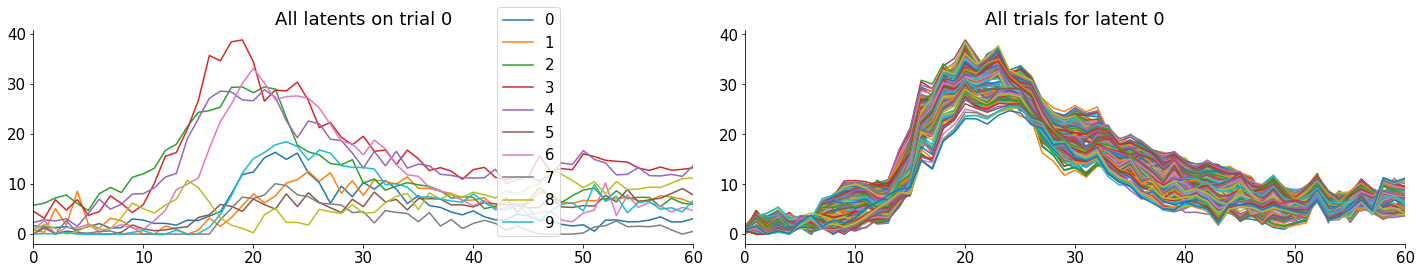

In [128]:
# Plot latent space
_, h = net(tr_nn)

hcpu = h.detach().cpu().numpy()
plt.figure(figsize=(20, 4))
plt.subplot(121)

print(hcpu.shape)


for c in np.arange(0,10):

  plt.plot(hcpu[:, 0, c], label = c);


plt.legend(loc='best', bbox_to_anchor=(0.5, 0., 0.5, 0.5))
plt.title('All latents on trial 0')
plt.xlim(0,60)


plt.subplot(122)
plt.plot(hcpu[:, :, 6]);
plt.title('All trials for latent 0')
plt.xlim(0,60)
plt.show()

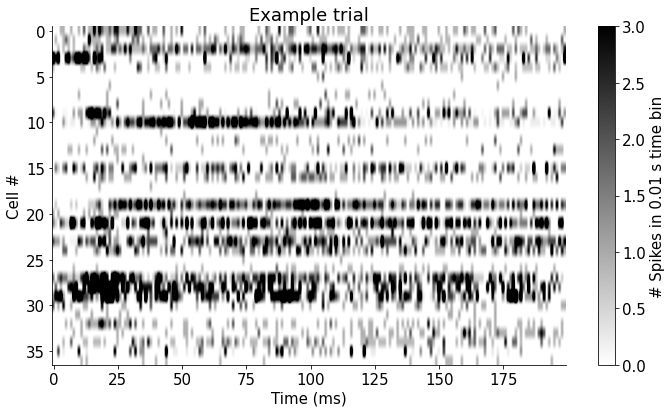

In [107]:
plt.figure(figsize = (10, 6))
plt.imshow(tr_nn.cpu().numpy()[:, 0, :].T, cmap='gray_r', vmax = 3, vmin=0, aspect='auto')
plt.xlabel('Time (ms)')
plt.ylabel('Cell #')
plt.colorbar(orientation='vertical', label='# Spikes in 0.01 s time bin')
plt.title('Example trial')
plt.show()

# **Extra**

In [108]:
# # Select session from which you want to extract the data
# dat = alldat[11]

# # Define one "macro" region of interest from which you want to extact the data, e.g. 0:"vis ctx", 1:"thal", etc. 
# ROI_number = 0 # take visual areas
# ROI = brain_groups[ROI_number]

# ROI_nn = []
# nn_per_area = [] # store the number of neurons in each sub area of a "macro area" for indexing

# nn_per_area = dict()

# indx_counter =0
# # Extract spikes from ROI:
# for r in ROI:
#   roi_nn = dat['spks'][dat['brain_area']==r]
#   ROI_nn.append(roi_nn)
#   if roi_nn.shape[0] >0:
#     indx_counter += roi_nn.shape[0] 
#     #nn_per_area.append((r,indx_counter)) # store n of neurons in that sub area
#     nn_per_area[r] = indx_counter

# # Put activations from same 'macro' area in the same tensor dimension  
# ROI_nn = np.concatenate(ROI_nn,axis=0)

# print(ROI_nn.shape)
# print(nn_per_area)




In [109]:

# CA3_nn = dat['spks'][dat['brain_area']=='CA3'][0].mean(axis=0)
# print(CA3_nn.shape)


# nn_number = np.arange(1, len(CA3_nn)+1)

# plt.plot(nn_number,CA3_nn)
# plt.show()